Loaded 1081 rows


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting CLIP embeddings: 100%|██████████| 1081/1081 [00:52<00:00, 20.49it/s]
/Users/roryashton/coding-repositories/ml-art-representation/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


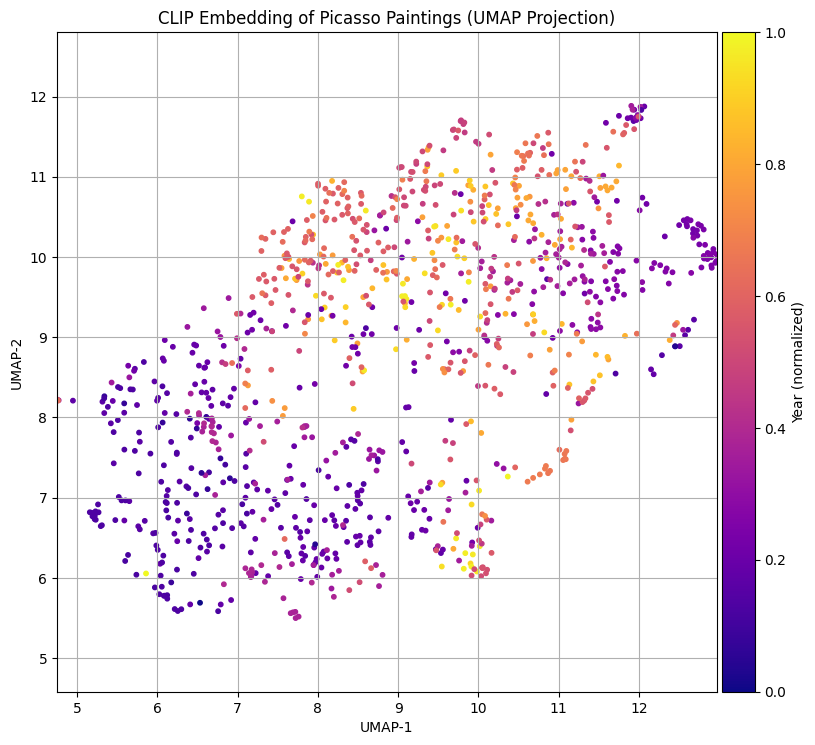

In [1]:
from pathlib import Path
import os
import pandas as pd
import torch
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPProcessor, CLIPModel
import base64
from io import BytesIO
from PIL import Image
import plotly.graph_objects as go
from IPython.display import display
# ipywidgets are optional; we'll fall back if unavailable
try:
    from ipywidgets import HTML as WHTML, HBox as WHBox
    WIDGETS_AVAILABLE = True
except Exception:
    WIDGETS_AVAILABLE = False

_HERE = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
_ROOT = _HERE.parent  # project root
DATA_DIR = _ROOT / "data" / "paintings"
CSV_PATH = _ROOT / "data" / "paintings.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} rows")

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return clip_processor(images=image, return_tensors="pt")["pixel_values"]

embeddings = []
failed_files = []

for filename in tqdm(df["filename"], desc="Extracting CLIP embeddings"):
    try:
        image_path = DATA_DIR / filename
        pixel_values = preprocess_image(image_path).to(DEVICE)

        with torch.no_grad():
            embedding = clip_model.get_image_features(pixel_values=pixel_values)
            embedding = embedding.squeeze().cpu().numpy()
            embeddings.append(embedding)
    except Exception as e:
        failed_files.append((filename, str(e)))
        embeddings.append([0.0] * 512)  # Dummy vector if fail

df["embedding"] = embeddings

embedding_matrix = pd.DataFrame(embeddings)
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embedding_matrix)

df["x"] = embedding_2d[:, 0]
df["y"] = embedding_2d[:, 1]

scaler = MinMaxScaler()
df["year_norm"] = scaler.fit_transform(df[["year"]])

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(9, 9))
scatter = ax.scatter(df["x"], df["y"], c=df["year_norm"], cmap="plasma", s=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label("Year (normalized)")
ax.set_title("CLIP Embedding of Picasso Paintings (UMAP Projection)")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.grid(True)
xmin, xmax = df['x'].min(), df['x'].max()
ymin, ymax = df['y'].min(), df['y'].max()
xc, yc = (xmin + xmax) / 2.0, (ymin + ymax) / 2.0
half = max(xmax - xmin, ymax - ymin) / 2.0
half = 0.5 if half <= 0 else half
ax.set_xlim(xc - half, xc + half)
ax.set_ylim(yc - half, yc + half)
ax.set_aspect('equal', adjustable='box')
# Ensure the axes box is square on screen if supported
try:
    ax.set_box_aspect(1)
except Exception:
    pass
plt.show()

In [ ]:
# Render UMAP scatter with thumbnail markers
from pathlib import Path
import sys

# Ensure notebook directory is importable for helper module
p = str(Path.cwd())
if p not in sys.path:
    sys.path.append(p)

from plot_thumbnail_scatter import plot_thumbnail_scatter

# Create normalized year if not present
if "year_norm" not in df.columns:
    from sklearn.preprocessing import MinMaxScaler
    df["year_norm"] = MinMaxScaler().fit_transform(df[["year"]])

fig = plot_thumbnail_scatter(
    df,
    DATA_DIR,
    color_by="year_norm",
    thumb_px=120,
    border_px=4,
    size_fraction=0.030,
    show_axes=True,
)
fig.update_layout(title="CLIP Embedding of Picasso Paintings (UMAP Projection)")
fig.show()
